# Pricing Project

Background: <br>In the solar industry, prospects that are from the source 'energy sage' typically ask for multiple quotes from multiple companies. Therefore, to win those customers from other competitors, it is important to know how the competitors are pricing their products. <br> In this script, we demonstrate how to price for a competitive order by first:<br>
(1) using machine learning to estimate the distribution of prices for each major competitor<br>
(2) choose a pricing that has the optimal balance between the risk of being higher than everyone else and how low the price is. 

load the data

In [1]:
import warnings 
import pandas as pd

In [2]:
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns

import pandas as pd
import warnings

import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [4]:
import pandas as pd

pge_data = pd.read_csv('Interconnection_Applications_Dataset_2023-08-31/PGE data.csv')
sce_data = pd.read_csv('Interconnection_Applications_Dataset_2023-08-31/SCE data.csv')
sdge_data = pd.read_csv('Interconnection_Applications_Dataset_2023-08-31/SDGE data.csv')

In [5]:
solar_data = pd.concat([pge_data,sce_data,sdge_data])

Delete data the original data to save space

In [6]:
del pge_data
del sdge_data
del sce_data

### Feature engineering

Deleting columns that are not contributive to estimating the price of a solar system. 

In [7]:
useless_columns = []
for i in range(4, 10):
    useless_columns.append('Generator Model '+ str(i))
    useless_columns.append('Generator Manufacturer '+ str(i))
    useless_columns.append('Generator Quantity ' + str(i))
    useless_columns.append('Inverter Model '+ str(i))
    useless_columns.append('Inverter Quantity '+ str(i))
    
solar_data.drop(useless_columns, axis = 1, inplace = True)

The brand of solar panel is an important determinant of price. Therefore, we want to extract the element of what the brand is.

In [8]:
# solar_data['Generator Model 1'].value_counts()[:50]

def compute_panel_type(df, column):
    list_a = []
    for i in df[column]:
#     print(i)
        if pd.isna(i):
            list_a.append('nan')
        elif i == 'Generic Module Model':
            list_a.append('Generic Module Model')
        elif i[:3] == 'SPR':
            list_a.append('SPR')
        elif i[:2] == 'Q.':
            list_a.append('Q.')
        elif i[:2] == 'LR' and str(3).isnumeric():
            list_a.append('LR')
        elif i[:3] == 'JAM':
            list_a.append('JAM')
        elif i[:3] == 'REC':
            list_a.append('REC')
        elif i[:3] == 'JKM':
            list_a.append('JKM')
        elif i[:2] == 'SW':
            list_a.append('SW ')
        elif i[:2] == 'YL':
            list_a.append( 'YL')
        elif i[:2] == 'LG':
            list_a.append("LG")
        elif i[:2] == 'KU':
            list_a.append('KU')
        elif i[:3] == 'TSM':
            list_a.append('TSM')
        elif i[:2] == 'SC' and i[2].isnumeric():
            list_a.append('SC')
        elif i[:2] == 'CS' and i[2].isnumeric():
            list_a.append('CS')
        elif i[:3] == 'TSM':
            list_a.append('TSM')
        elif i[:3] == 'DNA':
            list_a.append('DNA')
        elif i[:3] == 'VBN':
            list_a.append('VBN')
        elif i[:3] == 'VBH':
            list_a.append('VBH')
        elif i[:3] == 'MSE':
            list_a.append('MSE')
        elif i[0] == 'T' and i[1:4].isnumeric():
            list_a.append('T')
        elif i[:3] == 'SIL':
            list_a.append('SIL')
        elif i[:3] == 'BVM':
            list_a.append('BVM')
        elif i[:3] == 'HiS':
            list_a.append('HiS')
        elif i[:3] == 'VBN':
            list_a.append('VBN')
        elif i[:7] == 'Solaria':
            list_a.append('Solaria')
        elif i[:3] == 'EVP':
            list_a.append('EVP')
        elif i[:2] == 'SE' and i[2] == '-':
            list_a.append('SE')
        elif i[:2] == 'ET' and i[2] == '-':
            list_a.append('ET')
        elif i[:2] == 'KD' and i[2].isnumeric():
            list_a.append('KD')
        elif i[:2] == 'PM' and i[2].isnumeric():
            list_a.append('PM')
        elif i[:3] == 'SLA':
            list_a.append('SLA')
        elif i[:3] == 'SST':
            list_a.append('SST')
        elif i[:4] == 'WSMD':
            list_a.append('WSMD')
        elif i[:2] == 'SE' and i[2] == '-':
            list_a.append('SE')
        elif i[:3] == 'STP' :
            list_a.append('STP')
        elif (i[:2] == 'AC' and i[3:12] == 'Powerwall') or ('ACPowerwall' in i):
            list_a.append('AC Powerwall')
        elif i[:7] == 'Protect':
            list_a.append('Protect')
        elif i[:2] == 'ND':
            list_a.append('ND')
        elif i[:2] == 'BP':
            list_a.append('BP')
        elif i[:2] == 'IQ' and i[2].isnumeric():
            list_a.append('IQ')
        elif i[:2] == 'CT' and i[2:5].isnumeric():
            list_a.append('CT')
        elif i[:3] == 'OPT' and i[3:6]:
            list_a.append('OPT')
        elif i[:2] == 'JC' and i[3:6]:
            list_a.append('JC')
        elif i[:2] == 'NU' and i[2]== '-':
            list_a.append('NU-')
        elif 'Sunmodule' in i:
            list_a.append('Sunmodule')
        elif 'Powerwall 2' in i:
            list_a.append('Powerwall')
        elif i[:2] == 'SE' and i[2:6].isnumeric():
            list_a.append('SE0000')
        elif i[:2] == 'FF' and i[2] == '-':
            list_a.append('FF-')
        elif i[:2] == 'NT' and i[2] == '-':
            list_a.append('NT-')
        elif i[:2] == 'NE' and i[2] == '-':
            list_a.append('NE-')
        elif i[:3] == 'ZXM' and i[3].isnumeric():
            list_a.append('ZXM0')
        else:
            list_a.append('other')
    return list_a

In [9]:
solar_data['Panel Type 1'] = compute_panel_type(solar_data, 'Generator Model 1')
solar_data['Panel Type 2'] = compute_panel_type(solar_data, 'Generator Model 2')
solar_data['Panel Type 3'] = compute_panel_type(solar_data, 'Generator Model 3')



Make the zip code column categorical

In [10]:
solar_data['Service Zip'] = solar_data['Service Zip'].astype(str)
solar_data.shape

(1817962, 81)

In [11]:
solar_data[solar_data['Cost/Watt'] != 0 ]['Cost/Watt'].describe()

count    1.428490e+06
mean     4.650938e+00
std      2.224015e+00
min      1.000000e-06
25%      3.665869e+00
50%      4.564256e+00
75%      5.562043e+00
max      5.000000e+01
Name: Cost/Watt, dtype: float64

Preserving only residential solar system, since this project is about winning residential customers.

In [12]:
res_data = solar_data[solar_data['Customer Sector'] == 'Residential']
res_data.shape

(1776577, 81)

The maximum generation capacity of the panels is also contributive to price. Therefore,we will extract the maximum generation capacity of the panels too

In [13]:
panel_type = res_data['Generator Model 1'].str.extract(r'(\d{3})')
res_data['panel_size'] = panel_type
res_data['panel_size'] = res_data['panel_size'].astype(float)
res_data['panel_size'].fillna(0, inplace = True)

In [14]:
panel_type = res_data['Generator Model 2'].str.extract(r'(\d{3})')
res_data['panel2_size'] = panel_type
res_data['panel2_size'] = res_data['panel2_size'].astype(float)


In [15]:
res_data['panel2_size'].fillna(0, inplace = True)

In [16]:
panel_type = res_data['Generator Model 3'].str.extract(r'(\d{3})')
res_data['panel3_size'] = panel_type
res_data['panel3_size'] = res_data['panel3_size'].astype(float)

In [17]:
res_data['panel3_size'].fillna(0, inplace = True)

In [18]:
res_data.shape

(1776577, 84)

Standardizing the County column

In [19]:
lista = []
for i in res_data['Service County']:
    lista.append(i.lower())
res_data['Service County'] = lista

lista = []
for i in res_data['Service City']:
    lista.append(str(i).lower())
res_data['Service City'] = lista
# Deleting the data in 'alpine' County, because 
res_data = res_data[res_data['Service County'] != 'alpine']

The size and type of inverter could be important for price determination, so we want to preserve the 'inverter' column. We will:<br>
(1) Deleting unreasonable data points. Inverter/system Size ratio cannot be negative, nor can it be 0 or lower than 0.025. Therefore, we will delete these rows.<br>
(2) We will label those rows whose 'inverter' column in missing by adding a column 'inverter_value_missing'. Since we are using tree models to estimate price, and tree models are good at distinguishing abnormal values we will fill NA with negative -999. 

In [20]:
res_data = res_data[res_data['System Size DC'] > 0]
print(res_data.shape)
# res_data= res_data[res_data['Total System Cost'] > 0]

res_data['Inverter_value_missing'] = res_data['Inverter Size (kW AC)'].isnull().astype(int)
print(res_data.shape)
res_data['Inverter Size (kW AC)'].fillna(-999, inplace=True)
print(res_data.shape)



(1756128, 84)
(1756128, 85)
(1756128, 85)


In reality the inverter size cannot be 0, therefore, we will label the rows whose inverter to solar ratio is below 0.1 by adding a column '.

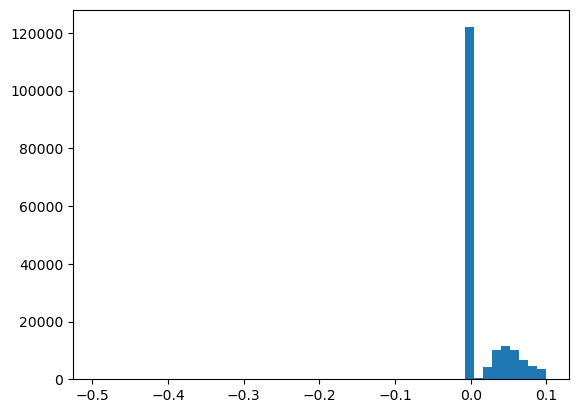

In [21]:
res_data['inverter_solar_ratio'] = res_data['Inverter Size (kW AC)']/res_data['System Size AC']
# plt.hist(exp[exp['indi'] < 0.5][exp['inverter_solar_ratio'] > 0.05]['indi'], bins = 100)
plt.hist(res_data['inverter_solar_ratio'][(res_data['Inverter Size (kW AC)']!=-999)&(res_data['inverter_solar_ratio'] < 0.1)&(res_data['inverter_solar_ratio'] >-0.5)], bins = 50)
plt.show()

In [22]:
res_data['Inverter_is_0'] = res_data['Inverter Size (kW AC)'].apply(lambda x:x== 0)
res_data['abnormally_small_inverter'] = res_data['inverter_solar_ratio'].apply(lambda x:(x > 0)&(x<0.2))

In [23]:
res_data.columns

Index(['Application Id', 'Preceding Id', 'Superceding Id',
       'Matched CSI Application Number', 'Application Status', 'Utility',
       'Service City', 'Service Zip', 'Service County', 'Technology Type',
       'System Size DC', 'System Size AC', 'Storage Capacity (kWh)',
       'Storage Size (kW AC)', 'Inverter Size (kW AC)', 'Tilt', 'Azimuth',
       'Mounting Method', 'Tracking', 'Customer Sector', 'App Received Date',
       'App Complete Date', 'App Approved Date', 'Decommissioned Date',
       'Self Installer', 'Installer Name', 'Installer Phone', 'Installer City',
       'Installer State', 'Installer Zip', 'CSLB Number', 'Third Party Owned',
       'Third Party Owned Type', 'Third Party Name', 'Pace Financed',
       'Pace Financier', 'Electric Vehicle', 'Electric Vehicle Count',
       'System Output Monitoring', 'System Output Reports To Vendor?',
       'System Output Monitoring Provider', 'Total System Cost',
       'Itc Cost Basis', 'Cost/Watt', 'NEM Tariff', 'Interconn

Processing Itc data. the column causes leakage, so it won't be used.

In [24]:
# res_data['Itc_value_missing'] = res_data['Itc Cost Basis'].isnull().astype(int)
# print(res_data.shape)
# res_data['Itc Cost Basis'].fillna(-99999, inplace=True)
# print(res_data.shape)

# plt.hist(res_data['Itc Cost Basis'][(res_data['Itc Cost Basis'] < 100) & (res_data['Itc Cost Basis'] > 0)], bins = 300)
# plt.show()

# res_data['Itc Cost Basis'].value_counts()

# res_data['weird_itc'] = res_data.apply(lambda x:(x['Inverter Size (kW AC)']/x['System Size DC'] < 0.025) & (x['Inverter Size (kW AC)'] != -999),

Processing energy storage column.

In [25]:

res_data ['Storage Size (kW AC)'] = res_data ['Storage Size (kW AC)'].fillna(0)

In [26]:
res_data.shape

(1756128, 88)

In [27]:
res_data['Inverter Size (kW AC)'].describe()

count    1.756128e+06
mean    -3.577149e+02
std      4.824202e+02
min     -8.149412e+03
25%     -9.990000e+02
50%      2.800000e+00
75%      5.235000e+00
max      7.625000e+03
Name: Inverter Size (kW AC), dtype: float64

In [28]:
exp = res_data[res_data['Total System Cost'] <100]

Standardizing company titles

In [32]:
res_data.shape

(1756128, 88)

In [33]:
import pandas as pd

# Assuming 'CompetitorStudy' is a DataFrame and it's already loaded in Python

# Create a dictionary mapping original strings to their replacements
replacements = {
    "california premier solar": "CaliforniaPremierSolar",
    "california solar systems": "CaliforniaSolarSystems",
    "clean energy solutions inc": "CleanEnergySolutionsInc",
    "energy remodeling": "EnergyRemodeling",
    "energyservicepartners": "energy service partners",
    "green convergence": "GreenConvergence",
    "home energy systems": "HomeEnergySystems",
    "new day solar": "NewDaySolar",
    "new power": "NewPower",
    "petersendean": "petersen dean",
    "solar 360": "solar360",
    "solaroptimum inc": "SolarOptimum",
    "solar permit": "SolarPermit",
    "solar service": "SolarService",
    "solar solutions": "SolarSolutions",
    "solar universie": "SolarUniverse",
    "Solar watt": "SolarWatt",
    "solar west": "SolarWest",
    "solar-360": "Solar360",
    "solarcitymh": "SolarCity",
    "south west": "SouthWest",
    "sun bees ": "SunBees",
    "sun energy": "SunEnergy",
    "sun solar": "SunSolar",
    "1st light energy inc": "Firstlight",
    "solar optimum": "SolarOptimum",
    "sunrun installation services inc":"Sunrun",
    "sunrun installation services, inc.":"Sunun",
    "solarcity corporation":"SolarCity",
    "tesla energy operations, inc.":"Tesla",
    "tesla energy operations inc":"Tesla",
    "SolarOptimum":"SolarOptimum",
    "n r g ":'nrg',
    "west coast":'WestCoast',
    "american array":"AmericanArray",
    "quality home":"QualityHomes",
    "quality homes":'QualityHomes',
    "solar 4 america":'Solar4America',
    "solar negotiators":"SolarNegotiators",
    "solar savings direct":"SolarSavingsDirect",
    "solar technologies":'SolarTechnologies',
    "solartech":'SolarTech',
    "west coast":'WestCoast',
    "american solar direct":"AmericanSolarDirect",
    "california solar electric co":"CaliforniaSolarElectric",
    "energy concepts":"EnergyConcepts",
    "energy savings pros":'EnergySavingPros',
    "energy service partners":"EnergyServicePartners",
    }

res_data['Installer Name'] = res_data['Installer Name'].apply(lambda x: str(x).lower())

# Process replacements using a while loop
keys = list(replacements.keys())
while keys:
    key = keys.pop()
    res_data['Installer Name'] = res_data['Installer Name'].str.replace(key, replacements[key]).str.lower()


In [34]:
res_data['Installer Name'].str.lower()

5                               solarcity
18                         solarcity corp
23                       occidental power
265                                akeena
266                  lavezzo construction
                       ...               
318815                         zing solar
318816                          solarcity
318817    semper solaris construction inc
318818                          solarcity
318819                          solarcity
Name: Installer Name, Length: 1756128, dtype: object

In [35]:
series1 = pd.Series(res_data['Installer Name'].value_counts()[:100].index.sort_values())
series2 = pd.Series(res_data['Installer Name'].value_counts()[:150].index.sort_values())

In [38]:

res_data['Installer Name'] =  res_data['Installer Name'].apply(lambda x: x.split()[0])

Top 50 companies will each be categorical variable, the rest will be classified as 'others'.

In [39]:
market_value = res_data['Installer Name'].value_counts().sum()

top_50_companies = pd.DataFrame(res_data['Installer Name'].value_counts()/market_value)[:100].index

res_data['Installer Name'] = res_data['Installer Name'].apply(lambda x: x if x in top_50_companies else 'other') 

In [40]:
res_data.shape

(1756128, 88)

In [41]:
reserve = res_data.copy()

### Importing zip code information income info

In [42]:
zip_info = pd.read_csv('zip2021.csv', dtype = {'zip':str})

In [43]:
res_data['Service Zip'] = res_data['Service Zip'].str.replace('.0','')

res_data['Installer Zip'] = res_data['Installer Zip'].astype(str).str.replace('.0','')

In [44]:
zip_info.columns = zip_info.iloc[0,:]

In [45]:
zip_info.drop([0],axis = 0, inplace = True)

In [46]:
zip_info['zip'] = zip_info['Geographic Area Name'].apply(lambda x:x[-5:])

In [47]:
columns = []
for i in zip_info.columns:
    if (('median' ) in str(i).lower() or ('mean' ) in str(i).lower() )and 'nonfamily' not in str(i).lower():
        columns.append(i)
    if ('population') in str(i).lower():
        columns.append(i)
zip_info.columns.shape

(260,)

In [48]:
zip_income = zip_info[['zip','Estimate!!Households!!Median income (dollars)','Estimate!!Households!!Mean income (dollars)']]
zip_income.columns = ['zip','median_income','mean_income']

In [49]:
zip_income['median_income'] = zip_income['median_income'].str.replace(',','')
zip_income['mean_income'] = zip_income['mean_income'].str.replace(',','')

zip_income['median_income'] = zip_income['median_income'].str.replace('+','')
zip_income['mean_income'] = zip_income['mean_income'].str.replace('+','')

zip_income['median_income'] = zip_income['median_income'].str.replace('-','')
zip_income['mean_income'] = zip_income['mean_income'].str.replace('-','')

In [50]:
zip_income['median_income'] = zip_income['median_income'].apply(lambda x:np.nan if x == '-' or x== 'N' else x)
zip_income['mean_income'] = zip_income['mean_income'].apply(lambda x:np.nan if x == '-' or x== 'N' else x)

In [51]:
zip_income['mean_income'].fillna(-9999, inplace = True)
zip_income['median_income'].fillna(-9999, inplace = True)

In [52]:
zip_income['median_income'].replace('',np.nan, inplace = True)
zip_income['mean_income'].replace('',np.nan, inplace = True)

In [53]:
zip_income['median_income'] = zip_income['median_income'].astype(float)
zip_income['mean_income'] = zip_income['mean_income'].astype(float)

In [54]:
res_data = pd.merge(res_data, zip_income, left_on = 'Service Zip', right_on = 'zip', how ='left')

In [55]:
res_data['median_income'].fillna(-999,inplace = True)
res_data['mean_income'].fillna(-999,inplace = True)

In [56]:
res_data.shape

(1756128, 91)

Importing longtitude and latitude

In [57]:
zips = pd.read_csv('uszips.csv', dtype = {'zip':str})


In [58]:
installer_zips = zips.copy()
installer_zips.columns = ['zip', 'installer_lat','installer_lng']

In [59]:
res_data = pd.merge(res_data, installer_zips, left_on = 'Installer Zip', right_on = 'zip', how = 'left')

In [60]:
res_data = pd.merge(res_data, zips, left_on = 'Service Zip', right_on = 'zip', how = 'left')

In [61]:
res_data.isna().sum()

Application Id                          0
Preceding Id                      1683402
Superceding Id                    1656166
Matched CSI Application Number    1624530
Application Status                      0
                                   ...   
installer_lat                      171139
installer_lng                      171139
zip                                 21280
lat                                 21280
lng                                 21280
Length: 97, dtype: int64

In [62]:
res_data['App Received Date'] = pd.to_datetime(res_data['App Received Date'])

# Extract year, month, and day
res_data['year'] = res_data['App Received Date'].dt.year
res_data['month'] = res_data['App Received Date'].dt.month
res_data['day'] = res_data['App Received Date'].dt.day

In [65]:
categorical_features = ['Service County', 'Installer Name','Inverter_value_missing',
                                                                'Inverter_is_0',
                                                                'abnormally_small_inverter']

for col in categorical_features:
    res_data[col] = res_data[col].astype('string')

In [66]:
exp_data = res_data[['System Size AC','Service County',
                     'lat', 'lng','Cost/Watt',
                     'Inverter Size (kW AC)',
                    'Storage Size (kW AC)','Installer Name','year','month',
                     'day', 'panel_size','panel2_size','panel3_size',
                    'installer_lat','installer_lng','Generator Quantity 1', 
                     'Generator Quantity 2','Inverter Quantity 1',
                     'Generator Quantity 3','Inverter_value_missing', 'Inverter_is_0',
                    'abnormally_small_inverter','median_income','mean_income']]

#'Total System Cost','Itc Cost Basis','NEM Tariff','Itc_value_missing','weird_itc'

In [67]:
selected_features = exp_data.columns[exp_data.columns != 'Cost/Watt']

In [68]:
exp_data['Generator Quantity 3'].fillna(0, inplace = True)
exp_data['Generator Quantity 2'].fillna(0, inplace = True)
exp_data['Generator Quantity 1'].fillna(0, inplace = True)
# exp_data['NEM Tariff'].fillna('unknown', inplace = True)
exp_data['lat'].fillna(0, inplace = True)
exp_data['lng'].fillna(0, inplace = True)
exp_data['installer_lat'].fillna(0, inplace = True)
exp_data['installer_lng'].fillna(0, inplace = True)
# exp_data['Total System Cost'].fillna(-99999, inplace = True)

In [69]:
# exp_data['NEM Tariff'] = exp_data['NEM Tariff'].astype(str)
exp_data['Generator Quantity 1'] = exp_data['Generator Quantity 1'].astype(float)
exp_data['Generator Quantity 2'] = exp_data['Generator Quantity 2'].astype(float)
exp_data['Generator Quantity 3'] = exp_data['Generator Quantity 3'].astype(float)
exp_data['Inverter Quantity 1'] = exp_data['Generator Quantity 1'].astype(float)

In [70]:
exp_data.dropna(subset = ['year','month','day'], inplace = True)

In [71]:
exp_data.isna().sum()

System Size AC                    0
Service County                    0
lat                               0
lng                               0
Cost/Watt                    351144
Inverter Size (kW AC)             0
Storage Size (kW AC)              0
Installer Name                    0
year                              0
month                             0
day                               0
panel_size                        0
panel2_size                       0
panel3_size                       0
installer_lat                     0
installer_lng                     0
Generator Quantity 1              0
Generator Quantity 2              0
Inverter Quantity 1               0
Generator Quantity 3              0
Inverter_value_missing            0
Inverter_is_0                     0
abnormally_small_inverter         0
median_income                     0
mean_income                       0
dtype: int64

In [72]:
y_column = 'Cost/Watt'

In [73]:
categorical_features = ['Service County', 'Installer Name','Inverter_value_missing',
                                                                 'Inverter_is_0',
                                                                'abnormally_small_inverter']

for col in categorical_features:
    exp_data[col] = exp_data[col].astype('category')

In [74]:
to_be_filled = exp_data[exp_data[y_column ].isna()]

In [75]:
exp_data = exp_data.dropna()

In [76]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Assuming exp_data is defined and has the required columns
y = exp_data[y_column]
X = exp_data.drop([y_column], axis=1)

# Make sure categorical_features is defined correctly
categorical_features = ['Service County', 'Installer Name','Inverter_value_missing',
                                                                'Itc_value_missing','weird_itc', 'Inverter_is_0',
                                                                'abnormally_small_inverter']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


params = {
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'lambda_l2': 1,
    'categorical_feature': categorical_features
}

mean_model = lgb.LGBMRegressor(**params)
mean_model.fit(X_train, y_train)

quantiles = np.linspace(0.05, 0.95, 19)
models = {}

for q in quantiles:
    print(f"Training model for {q * 100}% quantile")
    params['objective'] = 'quantile'
    params['alpha'] = q
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    models[f"quantile_{int(q * 100)}"] = model

    

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
Training model for 5.0% quantile
Training model for 10.0% quantile
Training model for 15.0% quantile
Training model for 20.0% quantile
Training model for 25.0% quantile
Training model for 30.0% quantile
Training model for 35.0% quantile
Training model for 40.0% quantile
Training model for 44.99999999999999% quantile
Training model for 49.99999999999999% quantile
Training model for 54.99999999999999% quantile
Training model for 60.0% quantile
Training model for 65.0% quantile
Training model for 70.0% quantile
Training model for 75.0% quantile
Training model for 80.0% quantile
Training model for 85.0% quantile
Training model for 90.0% quantile
Training model for 95.0% quantile


In [77]:
quantiles = np.linspace(0.05, 0.95, 19)

In [78]:
extra_two_models = [0.02, 0.98]
for q in extra_two_models:
    print(f"Training model for {q * 100}% quantile")
    params['objective'] = 'quantile'
    params['alpha'] = q
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    models[f"quantile_{int(q * 100)}"] = model


Training model for 2.0% quantile
Training model for 98.0% quantile


In [79]:
y_pred_mean = mean_model.predict(X_test)

In [80]:
feature_importance = pd.DataFrame({'columns': X.columns, 'importance':mean_model.feature_importances_}).sort_values('importance', ascending = False)[:]

In [81]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_mean)
print(f"r2: {r2}")

r2: 0.4021499934716626


In [82]:
feature_importance

,columns,importance
6,Installer Name,5890
0,System Size AC,3200
10,panel_size,2528
1,Service County,2474
14,installer_lng,2078
13,installer_lat,2065
7,year,2052
15,Generator Quantity 1,1589
4,Inverter Size (kW AC),1440
8,month,912


In [83]:
X = exp_data.drop(['Cost/Watt'], axis = 1)
feature_importance = pd.DataFrame({'columns': X.columns, 'importance':mean_model.feature_importances_}).sort_values('importance', ascending = False)[:]

In [84]:
to_be_filled.drop(['Cost/Watt'], axis = 1, inplace = True)

In [85]:
to_be_filled['Cost/Watt'] = mean_model.predict(to_be_filled)

In [86]:
new_df = pd.concat([exp_data, to_be_filled], axis=0)

In [87]:
# missing_cost_per_watt = to_be_filled['Cost/Watt'] 

# # Fill the DataFrame's x-axis (columns) with the Series values according to the index
# # for idx in missing_cost_per_watt.index:
# #     res_data['Cost/Watt'][idx] = missing_cost_per_watt[idx]
# for idx in missing_cost_per_watt.index:
#     res_data.at[idx, 'Cost/Watt'] = missing_cost_per_watt[idx]


In [88]:
df = new_df[['System Size AC']]
scaler = StandardScaler()

# Fit and transform the dataframe
df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


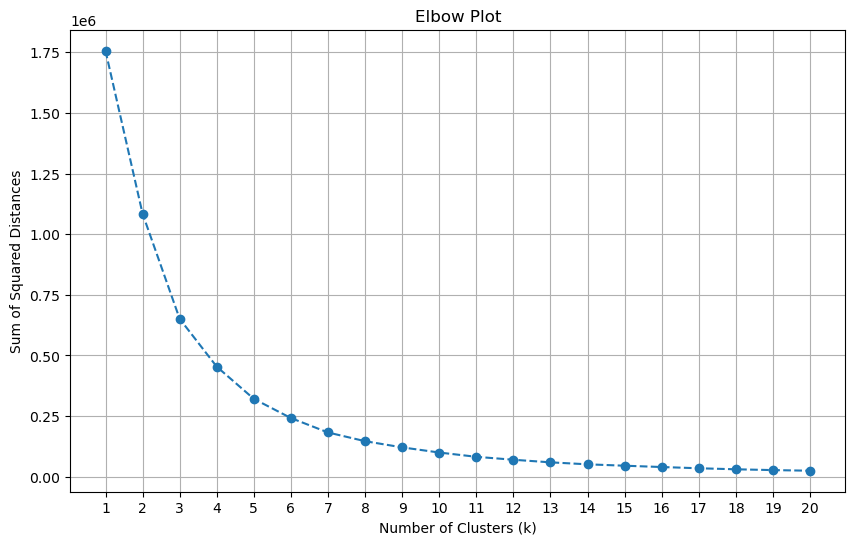

In [89]:
df = new_df[['System Size AC']]
import warnings
warnings.filterwarnings('ignore')


max_k = 20
sum_of_squared_distances = []

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_standardized )
    sum_of_squared_distances.append(kmeans.inertia_)  
    

plt.figure(figsize=(10,6))
plt.plot(range(1, max_k+1), sum_of_squared_distances, marker='o', linestyle='--')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.xticks(range(1, max_k+1))
plt.grid(True)
plt.show()
    

In [90]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_standardized)
kWh_cluster_labels = kmeans.labels_

In [91]:
new_df = new_df.dropna(subset = ['System Size AC'])

In [92]:
new_df['customer_type'] = kWh_cluster_labels

In [93]:


customer_segments = pd.DataFrame(kmeans.cluster_centers_)

customer_segments.columns = ['System Size AC']

customer_segments = pd.DataFrame(scaler.inverse_transform(customer_segments), columns=customer_segments.columns)

print(customer_segments)
print(pd.Series(kmeans.labels_).value_counts())



   System Size AC
0        3.814380
1        7.508238
2      277.698194
3       93.104172
4       13.631884
5      642.167740
0    993986
1    639905
4    121555
3       539
2        97
5        30
Name: count, dtype: int64


In [94]:
new_df['App Received Date'] = pd.to_datetime(new_df[['year', 'month', 'day']])

In [95]:

sample_data = new_df[pd.to_datetime(new_df['App Received Date']) > '2023-1-01']

to_be_guessed = sample_data[sample_data['Installer Name'] == 'solarmax'].sample(20)

In [96]:
import pandas as pd
from geopy.distance import geodesic




Now that we have trained the machine learning models (quantile regressions), we can generated a distribution of price for every prediction, so that for every price we choose we know how likely our price is lower than a competitors'.

In [97]:
def generate_distribution(series):
    values = list(series.round(2)) + [10000]
#     print(values)
    values = [values[i] if values[i-1] > values[i] else values[i-1] for i in range(1,len(values))]  

    generated_values = []
    generated_quantiles = []

# Iterate through each pair of neighboring values
    for i in range(len(values)-1):
        # Generate 100 values between each pair (excluding the endpoint to avoid duplication)
        num_computation = int(round((values[i + 1]-values[i])/0.01,0))
        if num_computation < 0:
            continue
#         print(num_computation)
        interval_values = np.linspace(values[i], values[i + 1], num = num_computation, endpoint=False)
        interval_quantile = np.linspace(quantiles[i],quantiles[i + 1], num=num_computation, endpoint=False)
        generated_values.extend(interval_values)
        generated_quantiles.extend(interval_quantile)

# Add the last value from the original array
    generated_values.append(values[-1])
    generated_quantiles.append(quantiles[-1])

# Convert the list to a NumPy array
    generated_values = np.array(generated_values).round(2)
    generated_quantiles = np.array(generated_quantiles)/100
    return generated_values, generated_quantiles


In [98]:
def is_within_radius(lat, long, x_latitude, x_longitude, radius= 2):
    """Check if a point is within a given radius (in miles) from point X"""
    distance = geodesic((x_latitude, x_longitude), (lat, long)).miles
    return distance <= radius


In [99]:
def find_competitors(i,new_df):
    x_latitude = i['lat']  # replace with the actual latitude of point X
    x_longitude = i['lng']  # replace with the actual longitude of point X
    customer_type = i['customer_type']
    date = pd.to_datetime(i['App Received Date'])
    recent_date = date - pd.Timedelta(days=120)
    recent_solar = new_df[(new_df['App Received Date'] > recent_date) & (new_df['App Received Date'] < date)].dropna(subset = ['lat','lng'])
    recent_relevant_solar = recent_solar[recent_solar['customer_type'] == customer_type]
    at_that_location = recent_relevant_solar.apply(lambda row: is_within_radius(row['lat'], row['lng'], x_latitude, x_longitude), axis = 1)
    recent_nearby_relevant_solar = recent_relevant_solar[at_that_location ]
    print(recent_nearby_relevant_solar[['Installer Name','installer_lat','installer_lng']].value_counts()[:5])
    top_competitors = recent_nearby_relevant_solar[['Installer Name','installer_lat','installer_lng']].value_counts()[:3].index
        
    return top_competitors

In [100]:
def compute_compet_info(quantiles, top_competitors, one_row_df):
    
    quantiles = (np.linspace(0.05, 0.95, 19)*100).astype(int)
    quantilte_df = pd.DataFrame(columns = quantiles)
    small_df = one_row_df.copy()
#     print(small_df.columns)
    small_df.drop(['customer_type', 'App Received Date', 'Cost/Watt'], axis = 1, inplace = True)
    for competitor in top_competitors:
        
#         print(competitor)
        small_df['Installer Name'] = competitor[0]
        small_df['installer_lat'] = competitor[1]
        small_df['installer_lng'] = competitor[2]
        small_df['Installer Name'] = small_df['Installer Name'].astype('category')

        lista = []

        for q in quantiles:

            lista.append(models[f"quantile_{q}"].predict(small_df))
#             
        lista = np.array(lista).flatten()
        y = pd.Series(lista)
        y.index = quantiles  
        index = str(competitor)
        quantilte_df.loc[index] = y 
    return quantilte_df

Example of a cumulative density distribution generated by the machine learning models

In [103]:
def compute_optimal_price(exp2, cost = 2.5, graph = True): 
    company_distribution = {}
    for index, i in exp2.iterrows():
        generated_values, generated_quantiles = generate_distribution(i)
        company_distribution[index] = (generated_values, generated_quantiles)
            

#         plt.figure(figsize=(8, 6))
#         plt.plot(generated_values, generated_quantiles, marker='o')
#         plt.xlabel('Quantiles')
#         plt.ylabel('Cumulative Density')
#         plt.title('Cumulative Density Distribution')
#         plt.grid(True)
#         plt.show()
    
    price_mins = []
    price_maxs = []
    for i in company_distribution:
        company_prices = company_distribution[i][0]
        price_mins.append(min(company_prices))
        price_maxs.append(max(company_prices))
    price_range = (max(price_mins), min(price_maxs))
#     print(price_range)
    price_range = np.linspace(price_range[0], price_range[1], int((price_range[1]-price_range[0])/0.01) ).round(2)
#     print(price_range.mean())
    profits = []
#     print(revs)
    for i in price_range:
        profit = i-cost
        for j in company_distribution:
            prob = pd.Series(company_distribution[j][1], index = company_distribution[j][0])[i]
            if isinstance(prob, pd.Series):
                prob = prob.iloc[0]
            profit = profit * (1-prob)
        profits.append(profit)
    price_and_return = pd.Series(profits, index = price_range)
    if graph == True:
        plt.bar(x = range(len(profits)), height = profits)
        plt.show()
    return price_and_return.idxmax()

In [ ]:
def compute_optimal_price2(exp2, cost = 2.5, graph = True): 
    company_distribution = {}
    for index, i in exp2.iterrows():
        generated_values, generated_quantiles = generate_distribution(i)
        company_distribution[index] = (generated_values, generated_quantiles)
    
    price_mins = []
    price_maxs = []
    for i in company_distribution:
        company_prices = company_distribution[i][0]
        price_mins.append(min(company_prices))
        price_maxs.append(max(company_prices))
    price_range = (max(price_mins), min(price_maxs))
#     print(price_range)
    price_range = np.linspace(price_range[0], price_range[1], int((price_range[1]-price_range[0])/0.01) ).round(2)
    print(price_range)
#     print(price_range.mean())
#     profits = []
# #     print(revs)
#     for i in price_range:
#         profit = i-cost
#         for j in company_distribution:
#             prob = pd.Series(company_distribution[j][1], index = company_distribution[j][0])[i]
#             if isinstance(prob, pd.Series):
#                 prob = prob.iloc[0]
#             profit = profit * (1-prob)
#         profits.append(profit)
#     price_and_return = pd.Series(profits, index = price_range)
#     if graph == True:
#         plt.bar(x = range(len(profits)), height = profits)
#         plt.show()
#     return price_and_return.idxmax()

In [ ]:
to_be_guessed.columns

In [108]:
top_competitors = []
competitors_info = []
for i in range(to_be_guessed.shape[0]):

    top_competitors = find_competitors(to_be_guessed.iloc[i], new_df)
    top_competitors.append(top_competitors)
    compet_info = compute_compet_info(quantiles, top_competitors, to_be_guessed.iloc[[i]])
    competitors_info.append(compet_info)
    
#     print(compet_info)
#     print(compute_optimal_price(compet_info, 2.5 ))

Installer Name  installer_lat  installer_lng
sunpower        37.92074       -122.34204       28
tesla           37.50653       -121.96361       25
solaroptimum    34.18221       -118.26761       20
sunrun          40.49865       -74.53284        15
other           34.08143       -117.73868        9
Name: count, dtype: int64
Installer Name  installer_lat  installer_lng
sunpower        37.92074       -122.34204       2
sunrun          40.49865       -74.53284        2
bright          33.64786       -117.92050       1
clean           34.15919       -118.08688       1
infinity        38.81982       -121.27772       1
Name: count, dtype: int64
Installer Name  installer_lat  installer_lng
sunrun          40.49865       -74.53284        8
energy          33.83497       -118.29291       8
tesla           37.50653       -121.96361       6
other           32.80347       -79.94561        5
a               34.28668       -118.43479       4
Name: count, dtype: int64
Installer Name  installer_lat  i

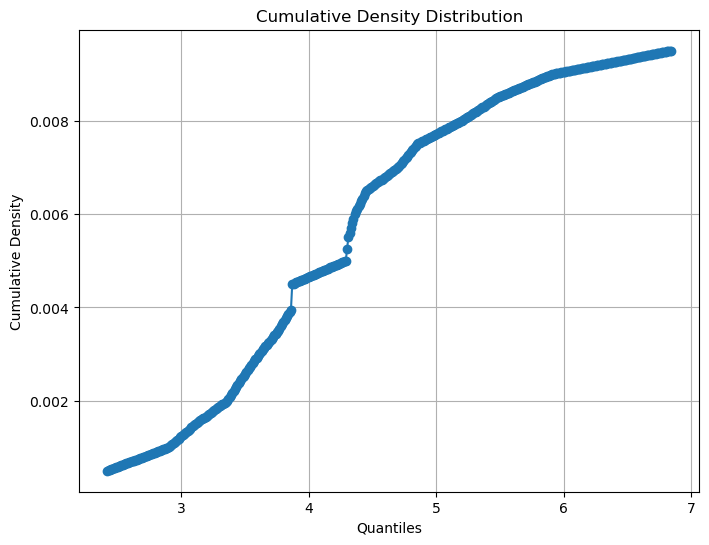

In [111]:
price, probability = generate_distribution(competitors_info[1].iloc[2])

plt.figure(figsize=(8, 6))
plt.plot(price, probability, marker='o')
plt.xlabel('Quantiles')
plt.ylabel('Cumulative Density')
plt.title('Cumulative Density Distribution')
plt.grid(True)
plt.show()

In [112]:
optimal_prices = []
for competitor_info in competitors_info:
    optimal_prices.append(compute_optimal_price(competitor_info, 2.0 , False))


In [117]:
exp = to_be_guessed.copy()
exp['Computed Optimal Price'] = optimal_prices
real_price_and_computed_price = exp[['Cost/Watt','Computed Optimal Price']]
real_price_and_computed_price.columns = ['Real Price', 'Computed Optimal Pirce']
print(real_price_and_computed_price)

         Real Price  Computed Optimal Pirce
1291902    1.288224                    2.63
1220762    4.357276                    5.97
1285948    3.587212                    4.72
1253938    2.749364                    5.34
1238289    3.972942                    6.05
1243321    5.165211                    5.67
1292602    3.566711                    4.87
1238447    5.130745                    4.72
1218830    5.703549                    4.99
1285732    3.954358                    5.78
1256727    2.420998                    7.93
1276423    4.888992                    5.09
1273232    5.771259                    5.03
1256542    4.850356                    5.42
1699719    3.374748                    6.60
1238084    3.517500                    3.90
1254377    3.960432                    5.94
1293387    3.437855                    3.43
1277579    3.373059                    4.82
1291880    3.753321                    5.74


# Next stage: test on quote data. Ideally, the quotes whose price are closer to the price computed by our methodology should have higher average profit.